In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Consistent plotting style
plt.style.use("default")
sns.set_theme(style="whitegrid")

# Colour palette (clean energy theme)
COLORS = {
    "blue": "#1764AB",
    "green": "#4CA466",
    "orange": "#D55E00",
    "grey": "#6E7D8C",
}

from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
# File path for carbon intensity dataset
PATH = "C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/processed/df_carbon.parquet"

# Keeps the DATETIME column as an index
df_carbon = pd.read_parquet(PATH)

# Sort Ascending order by index (DATETIME)
df_carbon = df_carbon.sort_index()

# Keep records within the modern period due to less fluctuation in data readings (determined in Notebook 02)
df_carbon = df_carbon[df_carbon.index >= "2020-01-01"]

# Adding Temperature Features

In [3]:
temp = pd.read_parquet(r"C:\Users\Krist\OneDrive\Documents\Data Analysis\Practice\Carbon\data\processed\uk_temp_hourly.parquet")
temp.index = pd.to_datetime(temp.index, utc=True)

df_carbon = df_carbon.sort_index()
temp = temp.sort_index()

df_merged = df_carbon.join(temp, how="left")

print("df_carbon range:", df_carbon.index.min(), "->", df_carbon.index.max(), "| rows:", len(df_carbon))
print("temp range:", temp.index.min(), "->", temp.index.max(), "| rows:", len(temp))

missing = df_merged["temp_2m"].isna().mean()
print(f"Missing temp_2m after merge: {missing:.2%}")

# Show where the missing starts (this is the important part)
first_missing = df_merged.index[df_merged["temp_2m"].isna()]
if len(first_missing) > 0:
    print("First missing temp timestamp:", first_missing[0])
    print("Last missing temp timestamp:", first_missing[-1])

df_carbon range: 2020-01-01 00:00:00+00:00 -> 2025-11-21 09:00:00+00:00 | rows: 51634
temp range: 2020-01-01 00:00:00+00:00 -> 2025-09-30 23:00:00+00:00 | rows: 50400
Missing temp_2m after merge: 2.39%
First missing temp timestamp: 2025-10-01 00:00:00+00:00
Last missing temp timestamp: 2025-11-21 09:00:00+00:00


A cap needs to be applied to 2025-09-30 23:00 UTC to match elecricity records.

In [4]:
cutoff = pd.Timestamp("2025-09-30 23:00:00", tz="UTC")
df_merged = df_merged.loc[:cutoff].copy()
print("Capped range:", df_merged.index.min(), "->", df_merged.index.max(), "| rows:", len(df_merged))
print("Missing after cap:", df_merged["temp_2m"].isna().mean())

Capped range: 2020-01-01 00:00:00+00:00 -> 2025-09-30 23:00:00+00:00 | rows: 50400
Missing after cap: 0.0


+ Time features
+ Lag features of CARBON_INTENSITY
+ Lag-1 of key mix features (to avoid leakage)

# Time features

In [5]:
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    return df

# Lag Features

In [6]:
def add_lag_features(df: pd.DataFrame, lags=(1, 24, 168)) -> pd.DataFrame:
    df = df.copy()
    for lag in lags:
        df[f"ci_lag_{lag}"] = df["CARBON_INTENSITY"].shift(lag)
    # 24h rolling mean to smooth noise
    df["ci_rollmean_24"] = df["CARBON_INTENSITY"].rolling(24).mean()
    return df

# Lagged mix features (1-hour lag)

In [7]:
MIX_COLS = [
    "FOSSIL", "COAL", "GAS", "NUCLEAR", "STORAGE",
    "GENERATION", "WIND", "HYDRO", "SOLAR", "BIOMASS",
    "RENEWABLE", "OTHER",
]

def add_mix_lag1(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in MIX_COLS:
        df[f"{col}_lag1"] = df[col].shift(1)
    return df

In [8]:
# Building the full Dataframe
df_feat = df_merged.copy()

df_feat = add_time_features(df_feat)
df_feat = add_lag_features(df_feat, lags=(1, 24, 168))
df_feat = add_mix_lag1(df_feat)

# Temperature features
df_feat["temp_2m_lag_1"] = df_feat["temp_2m"].shift(1)
df_feat["temp_2m_lag_24"] = df_feat["temp_2m"].shift(24)
df_feat["heating_degree_18"] = (18 - df_feat["temp_2m"]).clip(lower=0)
df_feat["cooling_degree_22"] = (df_feat["temp_2m"] - 22).clip(lower=0)
df_feat["temp_rollmean_24"] = df_feat["temp_2m"].rolling(24).mean()

The majority of the temperature features can be excluded as they add minimal difference to the final results.

In [9]:
# DROP
df_feat = df_feat.drop(
    columns=[
        "temp_2m_lag_1",
        "temp_2m_lag_24",
        "temp_rollmean_24",
        "heating_degree_18",
        "cooling_degree_22",
    ],
    errors="ignore",
)

In [10]:
# define target and drop rows with NaNs created by shifting/rolling
TARGET_COL = "CARBON_INTENSITY"
df_model = df_feat.dropna().copy()

y = df_model[TARGET_COL]

feature_cols = [
    col for col in df_model.columns
    if col not in (["CARBON_INTENSITY"] + MIX_COLS + ["LOW_CARBON", "ZERO_CARBON"])
]

X = df_model[feature_cols]

# Train / val / test split

In [11]:
train_mask = (df_model.index.year >= 2020) & (df_model.index.year <= 2023)
val_mask   = (df_model.index.year == 2024)
test_mask  = (df_model.index.year == 2025)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

In [12]:
# Sanity Check - Sizes
X_train.shape, X_val.shape, X_test.shape

((34896, 20), (8784, 20), (6552, 20))

In [13]:
# Shared evaluation helper
def evaluate_model(name, model, X_tr, y_tr, X_v, y_v, X_te, y_te):
    y_tr_pred = model.predict(X_tr)
    y_v_pred  = model.predict(X_v)
    y_te_pred = model.predict(X_te)

    def metrics(y_true, y_pred):
        mae  = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        return mae, rmse

    mae_tr, rmse_tr = metrics(y_tr, y_tr_pred)
    mae_v,  rmse_v  = metrics(y_v,  y_v_pred)
    mae_te, rmse_te = metrics(y_te, y_te_pred)

    print(f"\n=== {name} ===")
    print(f"Train: MAE={mae_tr:.2f}, RMSE={rmse_tr:.2f}")
    print(f"Val:   MAE={mae_v:.2f}, RMSE={rmse_v:.2f}")
    print(f"Test:  MAE={mae_te:.2f}, RMSE={rmse_te:.2f}")

    return {
        "name": name,
        "mae_tr": mae_tr, "rmse_tr": rmse_tr,
        "mae_v": mae_v,   "rmse_v": rmse_v,
        "mae_te": mae_te, "rmse_te": rmse_te,
    }

# Ridge regression

In [14]:
ridge = Ridge(alpha=1.0, random_state=42)

ridge.fit(X_train, y_train)

ridge_results = evaluate_model(
    "Ridge regression",
    ridge,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
)


=== Ridge regression ===
Train: MAE=8.05, RMSE=10.72
Val:   MAE=8.04, RMSE=10.91
Test:  MAE=8.92, RMSE=11.80


A simple linear model with time features + lags does not capture the non-linear behaviour of the grid.

# HistGradientBoostingRegressor

In [15]:
# This algorithm is faster than traditional gradient boosting for large datasets
gboost = HistGradientBoostingRegressor(
    max_depth=8,          # Maximum depth of the trees (controls complexity)
    learning_rate=0.05,   # Small learning rate for better generalization
    max_iter=300,         # Number of boosting iterations (trees)
    random_state=42       # Set seed for reproducibility
)

# Train the model on the training data
gboost.fit(X_train, y_train)

# Evaluate the model's performance on training, validation and test sets
# Results typically include metrics like RMSE, MAE, R² score
gboost_results = evaluate_model(
    "HistGradientBoostingRegressor",  # Model name for reporting
    gboost,                           # Trained model instance
    X_train, y_train,                 # Training data
    X_val,   y_val,                   # Validation data
    X_test,  y_test,                  # Test data
)


=== HistGradientBoostingRegressor ===
Train: MAE=4.85, RMSE=6.43
Val:   MAE=5.66, RMSE=7.64
Test:  MAE=5.89, RMSE=7.83


# Saving Predictions

In [16]:
pred_train = gboost.predict(X_train)
pred_val   = gboost.predict(X_val)
pred_test  = gboost.predict(X_test)

In [17]:
df_preds = pd.DataFrame({
    "CI_actual": y,        # full series
})

df_preds["CI_pred"] = np.nan

df_preds.loc[y_train.index, "CI_pred"] = pred_train
df_preds.loc[y_val.index,   "CI_pred"] = pred_val
df_preds.loc[y_test.index,  "CI_pred"] = pred_test

In [18]:
import os
os.makedirs("../data/predictions", exist_ok=True)
df_preds.to_parquet("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/predictions/ci_predictions.parquet")
print("DataFrame saved to C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/predictions/ci_predictions.parquet")

DataFrame saved to C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/data/predictions/ci_predictions.parquet


In [19]:
df_preds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50232 entries, 2020-01-08 00:00:00+00:00 to 2025-09-30 23:00:00+00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CI_actual  50232 non-null  float64
 1   CI_pred    50232 non-null  float64
dtypes: float64(2)
memory usage: 2.2 MB


# Feature importance ranking

In [20]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    gboost,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="neg_mean_absolute_error",
)

fi = pd.Series(perm.importances_mean, index=feature_cols).sort_values(ascending=False)

# Nice display
fi.head(20).map(lambda x: f"{x:.6f}")

ci_lag_1           58.672671
hour                4.851916
SOLAR_lag1          1.918995
ci_rollmean_24      0.431476
dayofweek           0.143760
GAS_lag1            0.129559
OTHER_lag1          0.094311
RENEWABLE_lag1      0.086542
STORAGE_lag1        0.074652
WIND_lag1           0.048805
ci_lag_24           0.040147
GENERATION_lag1     0.037561
temp_2m             0.035305
month               0.029856
ci_lag_168          0.017717
HYDRO_lag1          0.016470
FOSSIL_lag1         0.012219
BIOMASS_lag1        0.002551
COAL_lag1           0.000065
NUCLEAR_lag1       -0.013076
dtype: object

The modern UK grid is highly autoregressive, especially after 2020.
Carbon intensity is explained mostly by the previous hour and the daily demand curve, along with solar, are adding a predictable midday effect.
Mix-based features add value but do not dominate because the grid is now renewables-driven and less volatile when it comes to fossil output.

# Forecasting Plot: Actual vs Predicted

C:\Users\Krist\AppData\Local\Temp\ipykernel_4380\1144257443.py:13: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Krist\AppData\Local\Temp\ipykernel_4380\1144257443.py:15: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.savefig("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/assets/ci_actual_vs_pred_feb2024.png", dpi=150)
C:\Users\Krist\anaconda3\envs\UKCarbonProject\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


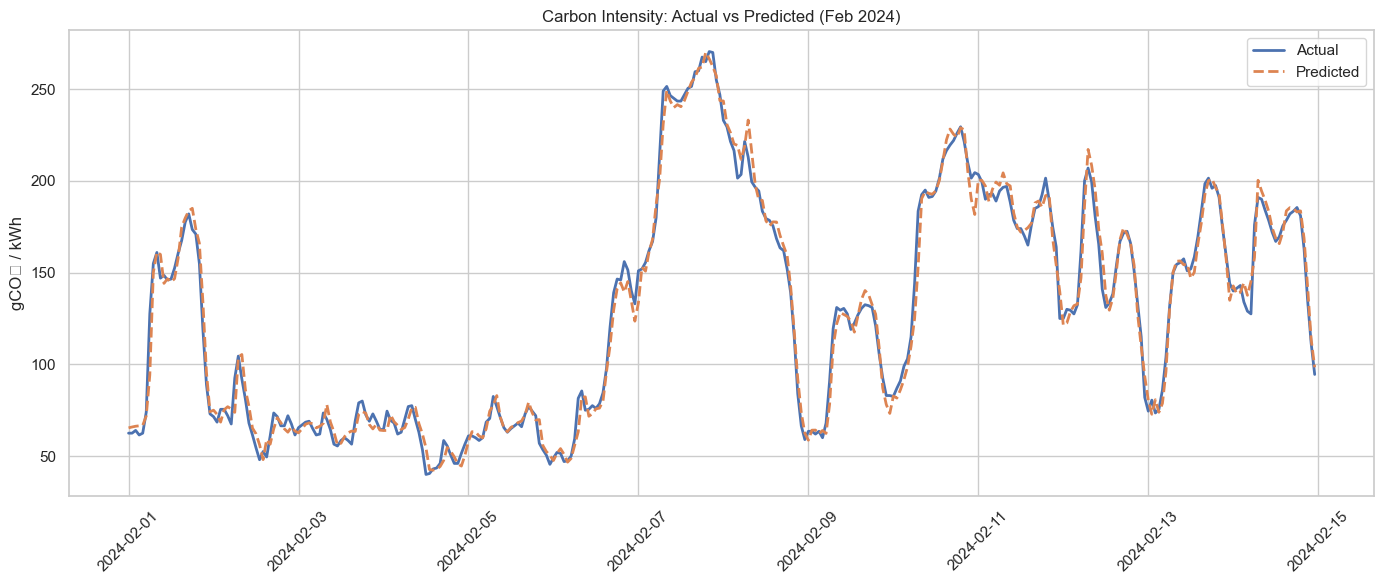

In [21]:
start = "2024-02-01"
end   = "2024-02-14"

subset = df_preds.loc[start:end]

plt.figure(figsize=(14, 6))
plt.plot(subset.index, subset["CI_actual"], label="Actual", linewidth=2)
plt.plot(subset.index, subset["CI_pred"], label="Predicted", linewidth=2, linestyle="--")
plt.ylabel("gCO₂ / kWh")
plt.title("Carbon Intensity: Actual vs Predicted (Feb 2024)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("C:/Users/Krist/OneDrive/Documents/Data Analysis/Practice/Carbon/assets/ci_actual_vs_pred_feb2024.png", dpi=150)
plt.show()

# Actual vs Predicted Carbon Intensity: Individual Day

C:\Users\Krist\AppData\Local\Temp\ipykernel_4380\3723856185.py:50: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Krist\anaconda3\envs\UKCarbonProject\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


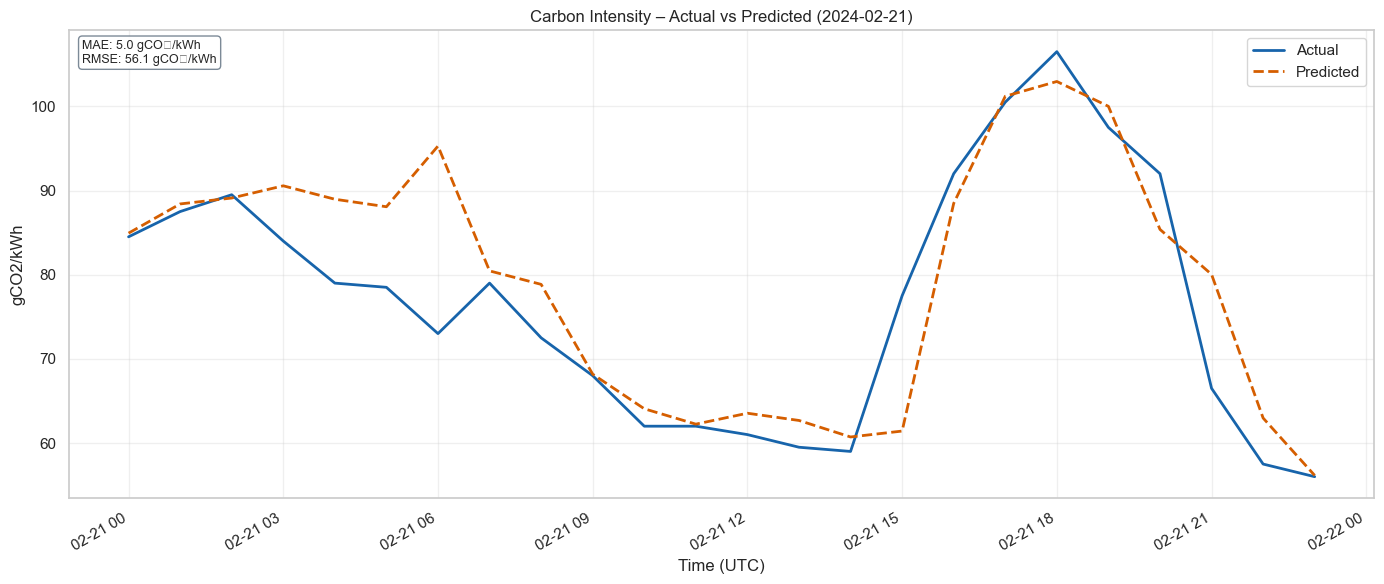

In [22]:
# Figure 1: Actual vs Predicted Carbon Intensity (Example Day)

example_date = "2024-02-21"  # change this if needed

ci_day = df_preds.loc[example_date, ["CI_actual", "CI_pred"]].copy()
ci_day = ci_day.sort_index()

mae = mean_absolute_error(ci_day["CI_actual"], ci_day["CI_pred"])
rmse = mean_squared_error(ci_day["CI_actual"], ci_day["CI_pred"])

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(
    ci_day.index,
    ci_day["CI_actual"],
    label="Actual",
    color=COLORS["blue"],
    linewidth=2,
)

ax.plot(
    ci_day.index,
    ci_day["CI_pred"],
    label="Predicted",
    color=COLORS["orange"],
    linewidth=2,
    linestyle="--",
)

ax.set_title(f"Carbon Intensity – Actual vs Predicted ({example_date})")
ax.set_ylabel("gCO2/kWh")
ax.set_xlabel("Time (UTC)")

ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

text = f"MAE: {mae:.1f} gCO₂/kWh\nRMSE: {rmse:.1f} gCO₂/kWh"
ax.text(
    0.01,
    0.98,
    text,
    transform=ax.transAxes,
    va="top",
    ha="left",
    fontsize=9,
    bbox=dict(boxstyle="round", fc="white", ec=COLORS["grey"], alpha=0.9),
)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Caption (for README/portfolio):
# "Actual vs predicted carbon intensity for a sample day in 2024.
#  The model tracks the main shape of the curve with relatively low error."

# Alt text:
# "Line chart showing actual and predicted hourly carbon intensity for a sample day,
#  with the two lines closely aligned across the 24-hour period."